# Why were the 2022-2023 Miami Heat able to go from Play-in to NBA Finals?

In [298]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In this analysis, I will be analyzing the 4 best teams from the 2022-2023 NBA playoffs: LA Lakers, Denver Nuggests(winners), Miami Heat, and Boston Celtics. In particular, I will be studying why the Miami Heat did so well, especially since they were a play-in team that NOBODY expected to make the NBA finals. Considering their roster, the Heat making the finals was considered an anomoly by many, so I wanted to see what in particular made the Heat so dangerous, but also why they still couldn't get over the hump and beat the Denver Nuggets.

## Functions I Wrote for Analysis

In [299]:
# def year_to_datetime(df, year_col_name):
#     out = []
#     for i in np.arange(df.shape[0]):
#         year_str = df.loc[i,year_col_name].split("-")[0]
#         out.append(pd.to_datetime(year_str, format = "%Y"))
#     df[year_col_name] = out
#     return df

#Filters the dataframe to only include stats from the input years
def year_filter(df, year_list):
    series = df['year'].isin(year_list)
    return df[series]

#Say you have 5 years worth of playoff data
#This function outputs a list with 5 entires. 
#Each entry is a df with player data from one year of playoffs
def split_data_by_year(df, year_list):
    df_list = []
    for i in year_list:
        df_list.append(df[df["year"] == i])
    return df_list

#Function will output stats for one team. 
#The optional arg outputs a list where output[1] gives the stats of the team that
#won the playoffs that year. Data should already be aggregated by year
def team_table(df, team, winner = False):
    if winner == False:
        out = df[df["TEAM"] == team]
        return out
    else:
        out = df[df["TEAM"] == team]
        out2 = df[df["Won_Playoffs"] == 1]
        return [out,out2]
    
def hists_over_diff_cats(features_list, df, team_list, bins='auto'):
    fig_list = []

    for i in np.arange(len(features_list)):
        fig, axs = plt.subplots(1, len(team_list), sharey=True, figsize=(12, 6))
        feature = features_list[i]

        
        fig.suptitle(feature, fontsize=16)

        x_min = min(df[feature])
        x_max = max(df[feature])

        for j in np.arange(len(team_list)):
            team = team_list[j]
            df_team = df[df["TEAM"] == team]

            axs[j].hist(df_team[feature], label=team, bins=bins, density=False, edgecolor="black")
            axs[j].set_title(team)
            axs[j].set_xlim([x_min, x_max])
            #axs[j].set_xticklabels(axs[j].get_xticklabels(), rotation=45, ha="right")

        fig_list.append(fig)

    plt.tight_layout()
    plt.show()


def percentile_table(df, feature_list):
    new_df = df[['year','PLAYER',"TEAM"]]
    for feat in feature_list:
            new_col = feat +"_Percentile"
            new_df[new_col] = df[feat].rank(pct=True)
    return new_df


def count_above_percentile_from_table(percentile_df, feature_list, percentile_threshold=0.70):
    # Initialize a dictionary to store counts
    count_dict = {}

    # Loop through each feature
    for feat in feature_list:
        # Define the column name for the percentile
        new_col = feat + "_Percentile"
        
        # Filter players who are above the threshold
        filtered_df = percentile_df[percentile_df[new_col] > percentile_threshold]
        
        # Count the number of players above the threshold per team
        count_per_team = filtered_df.groupby("TEAM").size()
       
        
        # Add the result to the dictionary
        count_dict[feat] = count_per_team
    
    # Convert the dictionary to a DataFrame
    count_df = pd.DataFrame(count_dict).fillna(0).astype(int)  # Fill NaN with 0 and convert to int
    team = count_df.index.tolist()
    #count_df["TEAM"] = team
    #count_df = count_df.reset_index()
    return count_df.reset_index()


def top_8_players_by_category(df, f):
    top_players = []

    for feature in f:
        # Sort the dataframe by the feature in descending order and take the top 5
        top_8 = df[['PLAYER', 'TEAM', feature]].sort_values(by=feature, ascending=False).head(8)
        
        # Add the top 5 players dataframe to the dictionary
        #top_players[feature] = top_8
        top_players.append(top_8)
    
    return top_players


def count_elite(df_list, team):
    count = 0
    
    ls = []
    for i in np.arange(len(df_list)):
        curr_tbl = df_list[i]
        elite_players = curr_tbl[curr_tbl["TEAM"] == team] 
        count = count + elite_players.shape[0]

        ls.append(elite_players)
    df = pd.concat(ls)
    if df.shape[0] > 0:
        print(team + " has a player that is top 8 in " + str(count) + " different stat categories.")
    else:
        print(team + " has no players that are top 8 in any stat category.")
    return df


    

    



## Cleaning the Data and Engineering New Features

First, I load in the data, which covers cumulative player stats over the past 5 NBA playoffs. Each row is a player, and each column is information regarding that player.

Next, I make a new column that says whether the player was on the team that won the playoffs (1) or not(0). This column is called "Won_Playoffs".

Then, I change the stats into averages per game as opposed to cumulative stats throughout the playoffs.

Finally, I extract just the 2023 playoff data to focus my analysis.

In [313]:
df = pd.read_csv("player.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,year,Season_type,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,AST_TOV,STL_TOV
0,0,468,2012-13,Playoffs,2544,1,LeBron James,1610612748,MIA,23,...,156,193,152,41,18,70,43,596,2.17,0.59
1,1,469,2012-13,Playoffs,2225,2,Tony Parker,1610612759,SAS,21,...,54,68,146,24,3,53,26,432,2.75,0.45
2,2,470,2012-13,Playoffs,1495,3,Tim Duncan,1610612759,SAS,21,...,160,214,40,18,34,42,53,381,0.95,0.43
3,3,471,2012-13,Playoffs,202331,4,Paul George,1610612754,IND,19,...,125,141,96,25,9,75,72,365,1.28,0.33
4,4,472,2012-13,Playoffs,2548,5,Dwyane Wade,1610612748,MIA,22,...,64,102,105,38,23,58,45,349,1.81,0.66


In [301]:

year_list = ["2019-20", "2020-21", "2021-22", "2022-23", "2023-24"]
df = year_filter(df, year_list)
winners = {
    'year': year_list,
    'winner': ['LAL', 'MIL', 'GSW', 'DEN', 'BOS']
}
winners_df = pd.DataFrame(winners)
df['Won_Playoffs'] = df.apply(lambda row: True if any((row['year'] == winners_df['year']) & (row['TEAM'] == winners_df['winner'])) else False, axis=1)
ls = ["Unnamed: 0.1", "Unnamed: 0", "TEAM_ID"]
df = df.drop(columns = ls)

cols = ['MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'AST_TOV',
       'STL_TOV']
df[cols] = df[cols].div(df['GP'], axis=0)
df.rename(columns={col: col + '_AVG' for col in cols}, inplace=True)
ls = ['year', 'RANK', 'PLAYER', 'TEAM', 'PTS_AVG', 'AST_AVG',  'REB_AVG', 'FG3_PCT','TOV_AVG',  'GP',
        'FGM_AVG', 'FGA_AVG', 'FG_PCT_AVG', 'FG3M_AVG', 'FG3A_AVG',
        'FTM_AVG', 'FTA_AVG', 'FT_PCT_AVG', 
       'BLK_AVG', 'PF_AVG',
        'AST_TOV_AVG', 'STL_TOV_AVG', 'MIN_AVG', 'OREB_AVG', 'DREB_AVG', 'STL_AVG', 'Won_Playoffs']
df = df[ls]
df.head()


,year,RANK,PLAYER,TEAM,PTS_AVG,AST_AVG,REB_AVG,FG3_PCT,TOV_AVG,GP,...,FT_PCT_AVG,BLK_AVG,PF_AVG,AST_TOV_AVG,STL_TOV_AVG,MIN_AVG,OREB_AVG,DREB_AVG,STL_AVG,Won_Playoffs
1472,2019-20,1,Anthony Davis,LAL,27.714286,3.476190,9.714286,0.383,2.523810,21,...,0.039619,1.428571,2.666667,0.065714,0.023333,36.619048,2.619048,7.095238,1.238095,True
1473,2019-20,2,LeBron James,LAL,27.619048,8.761905,10.761905,0.370,4.000000,21,...,0.034286,0.857143,1.904762,0.104286,0.014762,36.285714,1.333333,9.428571,1.238095,True
1474,2019-20,3,Jamal Murray,DEN,26.526316,6.631579,4.842105,0.453,2.789474,19,...,0.047211,0.315789,2.210526,0.125263,0.017895,39.631579,1.052632,3.789474,0.947368,False
1475,2019-20,4,Jimmy Butler,MIA,22.238095,6.047619,6.476190,0.349,2.809524,21,...,0.040905,0.666667,1.761905,0.102381,0.032857,38.380952,2.190476,4.285714,1.952381,False
1476,2019-20,5,Nikola Jokic,DEN,24.421053,5.736842,9.842105,0.429,3.263158,19,...,0.043947,0.789474,3.578947,0.092632,0.016842,36.526316,1.947368,7.894737,1.052632,False


In [302]:
year_list = ["2019-20", "2020-21", "2021-22", "2022-23", "2023-24"]
df_2023 = split_data_by_year(df, year_list)[3]
df_2023.head()

,year,RANK,PLAYER,TEAM,PTS_AVG,AST_AVG,REB_AVG,FG3_PCT,TOV_AVG,GP,...,FT_PCT_AVG,BLK_AVG,PF_AVG,AST_TOV_AVG,STL_TOV_AVG,MIN_AVG,OREB_AVG,DREB_AVG,STL_AVG,Won_Playoffs
2145,2022-23,1,Nikola Jokic,DEN,30.000000,9.500000,13.450000,0.461,3.500000,20,...,0.039950,1.000000,3.450000,0.135500,0.015000,39.450000,3.450000,10.000000,1.050000,True
2146,2022-23,2,Jimmy Butler,MIA,26.909091,5.863636,6.454545,0.359,1.863636,22,...,0.036636,0.636364,1.681818,0.143182,0.044545,39.727273,2.136364,4.318182,1.818182,False
2147,2022-23,3,Jayson Tatum,BOS,27.150000,5.250000,10.500000,0.323,2.800000,20,...,0.043800,1.050000,2.200000,0.094000,0.019000,39.950000,1.300000,9.200000,1.050000,False
2148,2022-23,4,Jamal Murray,DEN,26.100000,7.100000,5.650000,0.396,2.500000,20,...,0.046300,0.250000,2.050000,0.142000,0.030000,39.950000,0.750000,4.900000,1.500000,True
2149,2022-23,5,Jaylen Brown,BOS,22.650000,3.400000,5.600000,0.354,3.300000,20,...,0.034450,0.400000,3.050000,0.051500,0.016000,37.550000,1.250000,4.350000,1.050000,False


In [303]:
df.TEAM.unique()

array(['LAL', 'DEN', 'MIA', 'BOS', 'LAC', 'HOU', 'UTA', 'MIL', 'TOR',
       'DAL', 'OKC', 'ORL', 'PHI', 'POR', 'IND', 'BKN', 'PHX', 'ATL',
       'MEM', 'WAS', 'NYK', 'GSW', 'NOP', 'MIN', 'CHI', 'SAC', 'CLE'],
      dtype=object)

## Visualizing Number of Players for each Team who are the top 70th Percentile in Various Stats

Now, I want to see how many players are in the top 70th percentile for various stats per team. Any player in the top 70th percentile for a stat are considered above average and are "good" at that stat. I also want to see how many players are in the 85th percentile for various stats per team. Any player above the 85th percentile for a stat is considered well above average in that category, but not elite.

In [304]:
feats = ['PTS_AVG', 'AST_AVG',
       'FG3_PCT', 'OREB_AVG',
       'DREB_AVG', 'STL_AVG']
yo = percentile_table(df_2023,feats)

/var/folders/s1/kskcz1f94k71n1l5_1zw1kv40000gn/T/ipykernel_1760/1448545734.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[new_col] = df[feat].rank(pct=True)
/var/folders/s1/kskcz1f94k71n1l5_1zw1kv40000gn/T/ipykernel_1760/1448545734.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[new_col] = df[feat].rank(pct=True)
/var/folders/s1/kskcz1f94k71n1l5_1zw1kv40000gn/T/ipykernel_1760/1448545734.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [305]:
perc_tbl = count_above_percentile_from_table(yo, feats,.70)
perc_tbl


,TEAM,PTS_AVG,AST_AVG,FG3_PCT,OREB_AVG,DREB_AVG,STL_AVG
0,ATL,5,3,5,6,3,4
1,BKN,3,5,5,2,3,4
2,BOS,5,6,6,5,4,4
3,CLE,3,4,2,2,4,3
4,DEN,5,3,6,2,4,4
5,GSW,3,6,3,4,5,5
6,LAC,3,5,3,5,5,5
7,LAL,5,5,4,4,2,4
8,MEM,3,4,3,5,4,4
9,MIA,6,4,8,3,4,6


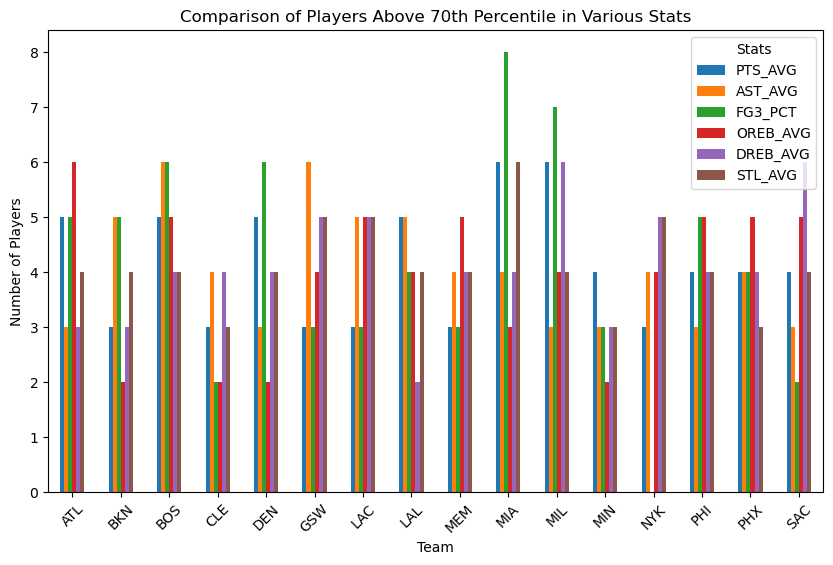

In [306]:
perc_tbl.set_index('TEAM').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Players Above 70th Percentile in Various Stats')
plt.xlabel('Team')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.legend(title='Stats')
plt.show()

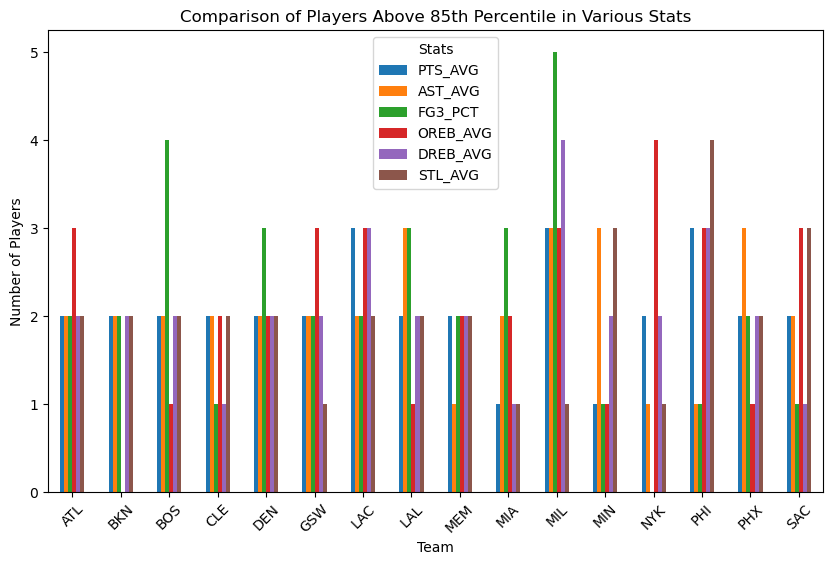

In [307]:
perc_tbl2 = count_above_percentile_from_table(yo, feats,.85)
perc_tbl2.set_index('TEAM').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Players Above 85th Percentile in Various Stats')
plt.xlabel('Team')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.legend(title='Stats')
plt.show()

The stats I will focus on are points average and 3 point percentage

### PTS_AVG

Boston, Denver, and the Lakers all had 5 players above the 70th percentile in average points per game. This means their starting 5 had above average points scored, which is what you expect from a good team's starting 5. Each of these teams along with many other playoff teams besides Miami had 2 players above the 85th percentile, which means they had 2 excellent scoreres. It is typical in most NBA roster construction to build around 2 super stars, so this makes sense. 

It appears that Miami had 6 players above the 70th percentile in average points per game. This means they had above average scoring from their starting 5 plus their 6th man. Amazingly, Miami only had 1 player above the 85th percentile in points per game, which was less than most NBA playoff teams. However, Miami outperformed many of these teams.

This suggests to me that is much better to have 6 slightly above average shooters as opposed to 2 incredible scorers.

### FG3_PCT

Miami had an astounding 8 players above 70th percentile in 3 point percentage. This indicates Miami had excellent 3 point shooting off the bench. Boston and Denver were the next 2 closest teams with 6 players above 70th percentile in 3 point percentage. The Lakers were weaker in this category with 4 players which makes sense. The Lakers rely on Lebron and AD who are good at 3s, but get most of their work in the paint and mid-range. The Lakers had a few solid role players, but their bench was much maligned that year, so it makes sense that good 3 point shooting was limited to the starters.

For players above the 85th percentile in 3 point percentage, Miami, LA, and Denver had 3. Boston had 4. Because the Lakers were the worst of these 4 teams, this suggests that it is much more important to have a group of slightly above average 3 point shooters in the starting line-up and on the bench as opposed to having a group with 3 starters that are excellent 3 point shooters, but the rest of the team is average to below average at shooting 3s.

### STL_AVG

Miami had 6 players above the 70th percentile in steals. Denver, LA, and Boston had 4 players above the 70th percentile in steals. This shows how active and aggressive the Miami players were in Spolstra's defensive scheme. They were getting above average seal production from their starters plus a bench player. Funny enough, Miami had only 1 player above the 85th percentile in steals. 

There seems to be a trend that Miami as a lot of slightly above average players in these stats across their starting line-up and bench. They don't have a lot of players above the 85th percentile in most stats, which indicates that solid production across the board is more important than elite production from a few players. However, if this is the case, why did the Nuggets beat the Heat?

## Top 8 Players across Various Stats

In [308]:
feats = ['PTS_AVG', 'AST_AVG',
       'FG3_PCT', 'OREB_AVG',
       'DREB_AVG', 'STL_AVG']

In [309]:
feats1= ['PTS_AVG_Percentile', 'AST_AVG_Percentile',
       'FG3_PCT_Percentile', 'OREB_AVG_Percentile', 'DREB_AVG_Percentile',
       'STL_AVG_Percentile']
p = top_8_players_by_category(yo, f = feats1)
p

[               PLAYER TEAM  PTS_AVG_Percentile
 2227    Kawhi Leonard  LAC            1.000000
 2153     Devin Booker  PHX            0.995392
 2182  Anthony Edwards  MIN            0.990783
 2151    Stephen Curry  GSW            0.986175
 2145     Nikola Jokic  DEN            0.981567
 2179       Trae Young  ATL            0.976959
 2155     Kevin Durant  PHX            0.972350
 2156    Jalen Brunson  NYK            0.967742,
                  PLAYER TEAM  AST_AVG_Percentile
 2179         Trae Young  ATL            1.000000
 2145       Nikola Jokic  DEN            0.995392
 2168       James Harden  PHI            0.990783
 2206       Jrue Holiday  MIL            0.986175
 2178       De'Aaron Fox  SAC            0.981567
 2207         Chris Paul  PHX            0.976959
 2193  Russell Westbrook  LAC            0.972350
 2194   Donovan Mitchell  CLE            0.967742,
                   PLAYER TEAM  FG3_PCT_Percentile
 2317    MarJon Beauchamp  MIL            0.990783
 2316       La

In [310]:
def count_elite(df_list, team):
    count = 0
    
    ls = []
    for i in np.arange(len(df_list)):
        curr_tbl = df_list[i]
        elite_players = curr_tbl[curr_tbl["TEAM"] == team] 
        count = count + elite_players.shape[0]

        ls.append(elite_players)
    df = pd.concat(ls)
    if df.shape[0] > 0:
        print(team + " has a player(s) that is top 8 in " + str(count) + " different stat categories.")
    else:
        print(team + " has no players that are top 8 in any stat category.")
    return df


In [311]:
count_elite(p,"DEN")

DEN has a player(s) that is top 8 in 4 different stat categories.


,PLAYER,TEAM,PTS_AVG_Percentile,AST_AVG_Percentile,FG3_PCT_Percentile,OREB_AVG_Percentile,DREB_AVG_Percentile,STL_AVG_Percentile
2145,Nikola Jokic,DEN,0.981567,NaN,NaN,NaN,NaN,NaN
2145,Nikola Jokic,DEN,NaN,0.995392,NaN,NaN,NaN,NaN
2145,Nikola Jokic,DEN,NaN,NaN,NaN,0.981567,NaN,NaN
2145,Nikola Jokic,DEN,NaN,NaN,NaN,NaN,0.995392,NaN


In [312]:
count_elite(p,"MIA")

MIA has a player(s) that is top 8 in 1 different stat categories.


,PLAYER,TEAM,PTS_AVG_Percentile,AST_AVG_Percentile,FG3_PCT_Percentile,OREB_AVG_Percentile,DREB_AVG_Percentile,STL_AVG_Percentile
2146,Jimmy Butler,MIA,NaN,NaN,NaN,NaN,NaN,0.974654


This shows that Miami had one truly elite player: Jimmy Butler in steals. Miami was essenially very well-balanced with one superstar player in Jimmy Butler

This shows that Denver had one elite player, but elite is an understatement. Nikola Jokic was top 8 in points, assists, offensive rebounds and defensive rebounds. This is complete and utter dominance to the highest degree. Denver had a strong starting 5, but their superstar was more like a super nova. It is hard for any team to compete against such a dominant player.

## Conclusion

My hypothesis for why this Heat team performed well lies in the number of above average players in points per game, 3 point percentage, and steals per game. They only had one top 8 player across all stats: Jimmy Butler in steals. However, their bench players showed to have above average production in the stats above. Although Boston had way more star power and a much better starting 5, their bench production doesn't come close to the production of Miami's. Thus, Miami was able to beat them out in the Eastern Conference Finals.

Despite that, Miami fell to Denver. This is for one reason and one reason alone: Nikola Jokic. Jokic was top 8 in a whopping 4 categories. I can't stress how ridiculously unfair that is. Although, Denver's bench wasn't as strong as Miami's, Jokic was simply too dominant for the Heat to overcome. 

From a roster construction stand point, the Heat show that it is better to have one elite player and then fill the roster with slightly above average players including the bench as opposed to a team filled with stars in the starting 5 and poor bench produciton. If a team is going the traditional route of using most of the cap for 2 superstars and filling the rest of the team with good to below average players, their superstar needs to be completely dominant, like Jokic. 

Essentially, the Heat had a more complete team with robust bench production, but Jokic was too much of a game-breaker. He not only scores and creates opportunities for his teammates, he also rebounds super well. Even though the Heat's bench was much better than the Nugget's bench, the minutes without Jokic were too one-sided.